In [1]:
import matplotlib.pyplot as plt
import fenics as fe
import mshr
import numpy as np
from scipy.linalg import eigh

In [127]:
# Input parameters
mesh_resolution = 3
monte_carlo_samples = 80
# 2 and 100 takes about 36 seconds
# 3 and 80 takes about 3 minutes
# 3 and 100 takes about 5 minutes

def cov1_1(x, y):
    return 5.0/100.0 * np.exp(-4.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))
def cov1_2(x, y):
    return 1.0/100.0 * np.exp(-0.1 * ((2*x[0] - y[0])**2 + (2*x[1] - y[1])**2))
def cov2_1(x, y):
    return 1.0/100.0 * np.exp(-0.1 * ((x[0] - 2*y[0])**2 + (x[1] - 2*y[1])**2))
def cov2_2(x, y):
    return 5.0/100.0 * np.exp(-1.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))

In [128]:
# Helpers
class BasisFunction():
    def __init__(self, basis_function: fe.Function, coordinates: np.array):
        self.function = basis_function
        self.coordinates = coordinates

def get_max_edge_length(mesh):
    max_length = 0
    for cell in fe.cells(mesh):
        vertices = np.array(cell.get_vertex_coordinates()).reshape((-1, 2))
        edge_lengths = np.linalg.norm(np.roll(vertices, -1, axis=0) - vertices, axis=1)
        max_length = max(max_length, np.max(edge_lengths))
    return max_length

def get_C_entry(f, basis_function_i: BasisFunction, basis_function_j: BasisFunction, max_edge_length: float):
    def integrand(x, y):
        return f(x, y) * basis_function_i.function(x) * basis_function_j.function(y)
    # generate MC samples
    angles_x = np.random.uniform(0, 2 * np.pi, monte_carlo_samples)
    radii_x = np.sqrt(np.random.uniform(0, max_edge_length, monte_carlo_samples))
    x1_samples = basis_function_i.coordinates[0] + radii_x * np.cos(angles_x)
    x2_samples = basis_function_i.coordinates[1] + radii_x * np.sin(angles_x)
    angles_y = np.random.uniform(0, 2 * np.pi, monte_carlo_samples)
    radii_y = np.sqrt(np.random.uniform(0, max_edge_length, monte_carlo_samples))
    y1_samples = basis_function_j.coordinates[0] + radii_y * np.cos(angles_y)
    y2_samples = basis_function_j.coordinates[1] + radii_y * np.sin(angles_y)
    C_entry = 0
    for (x1, x2) in zip(x1_samples, x2_samples):
        for (y1, y2) in zip(y1_samples, y2_samples):
            C_entry += integrand([x1, x2], [y1, y2])
    return C_entry / (monte_carlo_samples**2) * np.pi * max_edge_length**2

        Building point search tree to accelerate distance queries.
        Computed bounding box tree with 63 nodes for 32 points.


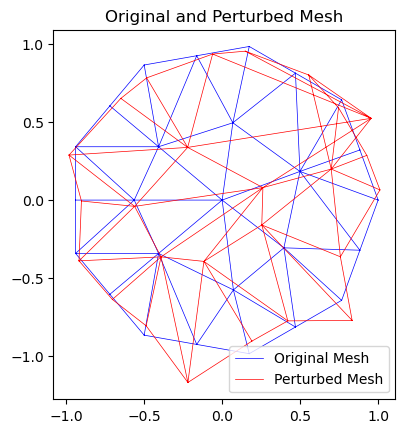

In [129]:
# Create a mesh
domain = mshr.Circle(fe.Point(0, 0), 1)  # Center, radius
mesh = mshr.generate_mesh(domain, mesh_resolution)
max_edge_length = get_max_edge_length(mesh)

# Define function spaces
V = fe.FunctionSpace(mesh, "CG", 1)
V_Vector = fe.VectorFunctionSpace(mesh, "CG", 1)
N = V.dim()
dof_coordinates = V.tabulate_dof_coordinates().reshape((-1, 2))

basis_functions = []
basis_functions_grads = []
for i in range(N):
    basis_function = fe.Function(V)
    basis_function.vector()[i] = 1.0
    basis_function.set_allow_extrapolation(True)
    basis_functions.append(BasisFunction(basis_function, dof_coordinates[i]))
    grad = fe.project(fe.grad(basis_function), V_Vector)
    grad.set_allow_extrapolation(True)
    basis_functions_grads.append(BasisFunction(grad, dof_coordinates[i]))

C = np.zeros((2 * N, 2 * N))
for i, basis_function_i in enumerate(basis_functions):
    for j, basis_function_j in enumerate(basis_functions):
        if j <= i: #! This should be done in the loop itself
            # Here we use that each block is symmetric because of the symmetry of the covariance functions
            C[i, j] = C[j, i] = get_C_entry(cov1_1, basis_function_i, basis_function_j, max_edge_length)
            C[i, N + j] = C[j, N + i] = get_C_entry(cov1_2, basis_function_i, basis_function_j, max_edge_length)
            C[N + i, j] = C[N + j, i] = get_C_entry(cov2_1, basis_function_i, basis_function_j, max_edge_length)
            C[N + i, N + j] = C[N + j, N + i] = get_C_entry(cov2_2, basis_function_i, basis_function_j, max_edge_length)
# print(f"C: {C}")

M = np.zeros((2 * N, 2 * N))
for i, basis_function in enumerate(basis_functions):
    integrand = basis_function.function * basis_function.function * fe.dx
    M[i, i] = M[N + i, N + i] = fe.assemble(integrand)
# print(f"M: {M}")


J = N # Number of eigenvectors -> J = N is maximum
eigenvalues, eigenvectors = eigh(C, M, subset_by_index=[0, J-1])
# Print the eigenvalues and eigenvectors -> important to test if MC-sample size is large enough
# print(f"Eigenvalues: {eigenvalues}")
# print(f"Eigenvectors: {eigenvectors}")

# Eliminate negative eigenvalues
for index, eigenvalue in enumerate(eigenvalues):
    if eigenvalue < 0:
        eigenvalues[index] = 0
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), J)

# perturbed mesh based on the "original" mesh used for the KL-expansion
perturbed_coordinates = mesh.coordinates().copy()
for index, coordinate in enumerate(mesh.coordinates()):
    perturbed_coordinates[index][0] += sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions[k].function(coordinate) for k in range(N)]) * xi[j] for j in range(J)])
    perturbed_coordinates[index][1] += sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions[k].function(coordinate) for k in range(N)]) * xi[j] for j in range(J)])

# Create a new mesh with the perturbed coordinates
perturbed_mesh = fe.Mesh(mesh)
perturbed_mesh.coordinates()[:] = perturbed_coordinates

# Plot the original mesh and the perturbed mesh in one figure with different colors
plt.figure()
fe.plot(mesh, color='blue', linewidth=0.5, label='Original Mesh')
fe.plot(perturbed_mesh, color='red', linewidth=0.5, label='Perturbed Mesh')
plt.legend()
plt.title(f"Original and Perturbed Mesh")
plt.show()

In [130]:
def random_field(x):
    return x[0] + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions[k].function(x) for k in range(N)]) * xi[j] for j in range(J)]), \
           x[1] + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions[k].function(x) for k in range(N)]) * xi[j] for j in range(J)])

def jacobian(x):
    jacobian_output = np.zeros((2, 2))
    jacobian_output[0, 0] = 1 + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[0, 1] = sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[1, 0] = sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions_grads[k].function(x)[1] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[1, 1] = 1 + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    return jacobian_output

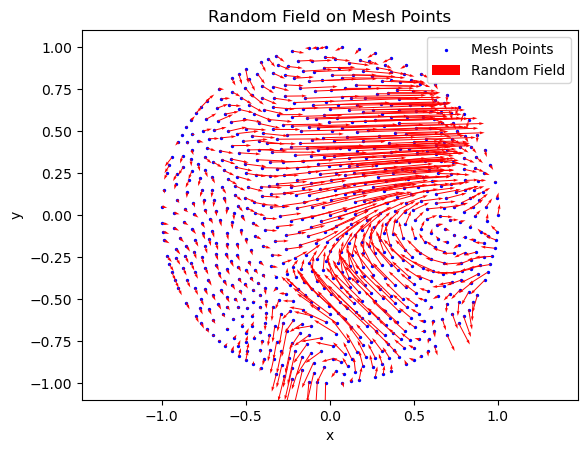

In [131]:
fine_mesh_coordinates = mshr.generate_mesh(domain, 20).coordinates()
random_field_values = np.array([random_field(coord.copy()) for coord in fine_mesh_coordinates])
plt.figure()
plt.scatter(fine_mesh_coordinates[:, 0], fine_mesh_coordinates[:, 1], color='blue', s=2, label='Mesh Points')
plt.quiver(fine_mesh_coordinates[:, 0], fine_mesh_coordinates[:, 1], 
           random_field_values[:, 0] - fine_mesh_coordinates[:, 0], 
           random_field_values[:, 1] - fine_mesh_coordinates[:, 1], 
           color='red', scale=1, scale_units='xy', angles='xy', width=0.002, label='Random Field')
plt.title("Random Field on Mesh Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

        Solving linear variational problem.


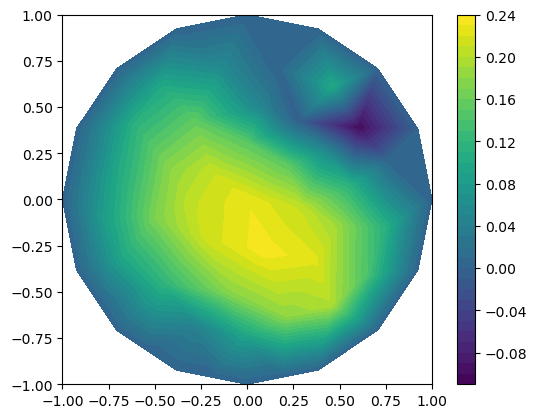

In [132]:
class AExpression(fe.UserExpression):
    def eval(self, values, x):
        J_x = jacobian(x)
        inv_JTJ = np.linalg.inv(J_x.T @ J_x)
        det_J = np.linalg.det(J_x)
        A_x = inv_JTJ * det_J
        values[0] = A_x[0, 0]
        values[1] = A_x[0, 1]
        values[2] = A_x[1, 0]
        values[3] = A_x[1, 1]

    def value_shape(self):
        return (2, 2)

mesh_resolution_fem = 5 
# 32 takes about 5,5 minutes

domain = mshr.Circle(fe.Point(0, 0), 1)
mesh = mshr.generate_mesh(domain, mesh_resolution_fem)
V = fe.FunctionSpace(mesh, 'P', 1)
u = fe.TrialFunction(V)
v = fe.TestFunction(V)

# Define the bilinear form a(u, v)
A_expr = AExpression(degree=2)
a = fe.inner(fe.dot(A_expr, fe.grad(u)), fe.grad(v)) * fe.dx

# Define the linear form L(v)
f_ref = fe.Constant(1.0)
L = f_ref * v * fe.dx

# Apply the Dirichlet boundary condition u = 0 on the boundary of D_ref
bc = fe.DirichletBC(V, fe.Constant(0), 'on_boundary')

# Solve the variational problem
u_sol = fe.Function(V)
fe.solve(a == L, u_sol, bc)

# Plot the solution
c = fe.plot(u_sol)
# fe.plot(mesh)
plt.colorbar(c)
plt.show()